In [25]:
#Load pandas library
import pandas as pd
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter
#for DTC
import numpy as np
from math import log
import operator
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Google Drive connection (as a fallback)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
def load_customer_churn_data(kaggle_file_path, google_drive_file_path):
    df = None

    #Option 1: Load from KaggleHub
    print("Attempting to load data from KaggleHub...")
    try:
        df = kagglehub.load_dataset(
            KaggleDatasetAdapter.PANDAS,
            "rodolfomendes/abalone-dataset",
            kaggle_file_path,
        )
        print("Successfully loaded data from KaggleHub.")
    except Exception as e:
        print(f"KaggleHub loading failed: {e}")
        print("Falling back to Google Drive...")

        #Option 2: Load from Google Drive
        try:
            df = pd.read_csv(google_drive_file_path)
            print("Successfully loaded data from Google Drive.")
        except Exception as gd_e:
            print(f"Google Drive loading failed: {gd_e}")
            print("Could not load data from either source. Please check file paths and permissions.")
            return None # Return None if data cannot be loaded

    if df is None:
        return None
    return df

#Loading and Pre-processing Abalone Dataset
##Data Cleaning:
1. Check and Handle Missing Values
2. Check and Handle Duplicate Rows

##1. Check and Handle Missing Values

In [27]:
# Define file paths for loading
kaggle_dataset_file = 'abalone.csv'
google_drive_full_path = '/content/drive/MyDrive/FAI-GrpAssn/abalone.csv'

# Call the loading function
df = load_customer_churn_data(kaggle_dataset_file, google_drive_full_path)

if df is not None:
    print('\n')
    print("First 5 records:", df.head())
    print('\n')
    print(df.info())
    print('\n')
    print(df.describe())
    print('\n')
    # Display rows with any missing values
    missing_rows = df[df.isnull().any(axis=1)]
    print('Rows with missing values:')
    display(missing_rows)
else:
    print("Data loading failed. 'df' is not available.")

Attempting to load data from KaggleHub...


/tmp/ipython-input-2678473744.py:7: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'abalone-dataset' dataset.
Successfully loaded data from KaggleHub.


First 5 records:   Sex  Length  Diameter  Height  Whole weight  Shucked weight  Viscera weight  \
0   M   0.455     0.365   0.095        0.5140          0.2245          0.1010   
1   M   0.350     0.265   0.090        0.2255          0.0995          0.0485   
2   F   0.530     0.420   0.135        0.6770          0.2565          0.1415   
3   M   0.440     0.365   0.125        0.5160          0.2155          0.1140   
4   I   0.330     0.255   0.080        0.2050          0.0895          0.0395   

   Shell weight  Rings  
0         0.150     15  
1         0.070      7  
2         0.210      9  
3         0.155     10  
4         0.055      7  


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null 

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings


There are no rows with missing values hence there are none to handle.

##2. Check and Handle Duplicate Rows
    - subset: List of columns to consider for identifying duplicates. Default is None (all columns are considered)
    - keep: Specifies which duplicates to keep
    ('first' keeps the first occurrence, 'last' keeps the last, and False removes all duplicates)

In [28]:
def remove_duplicated_rows(df, subset=None, keep='first'):

    num_rows_before = df.shape[0]
    duplicated_rows = df.duplicated(subset=subset, keep=keep).sum()

    cleaned_df = df.drop_duplicates(subset=subset, keep=keep)

    num_rows_after = cleaned_df.shape[0]
    rows_removed = num_rows_before - num_rows_after

    print(f"Number of duplicated rows removed: {duplicated_rows}")
    print(f"Total rows removed: {rows_removed}")
    return cleaned_df

In [29]:
#call the duplicate row removal function
df_no_duplicates = remove_duplicated_rows(df)
#extra check to ensure duplicates are removed
print(df_no_duplicates.info())

Number of duplicated rows removed: 0
Total rows removed: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4177 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB
None


#Exploratory Data Analysis (EDA)

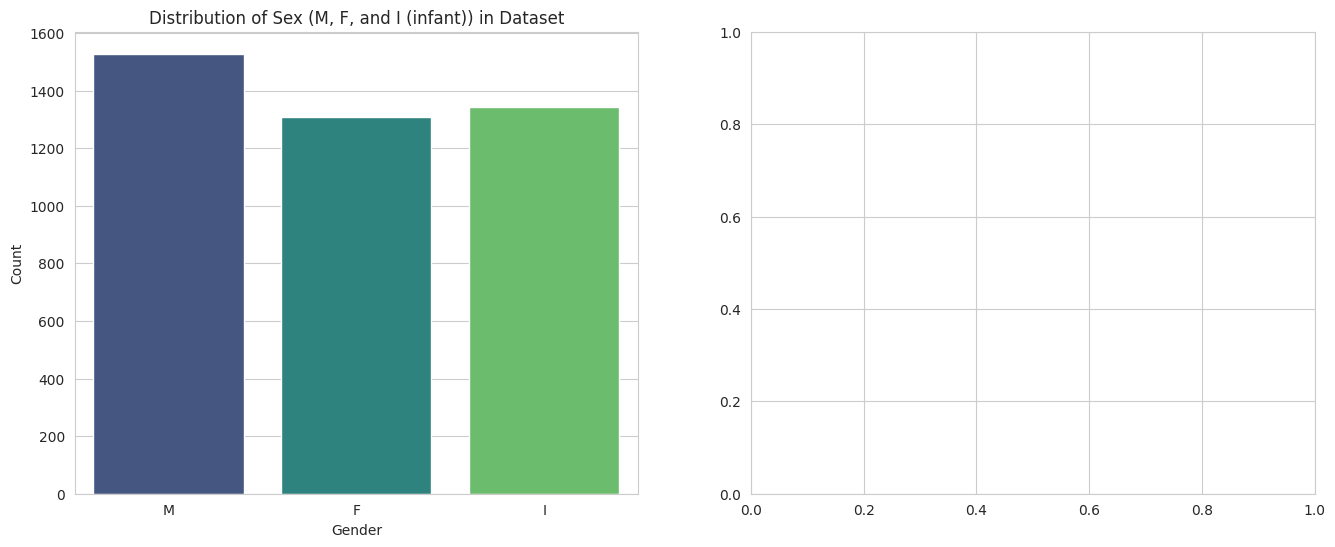

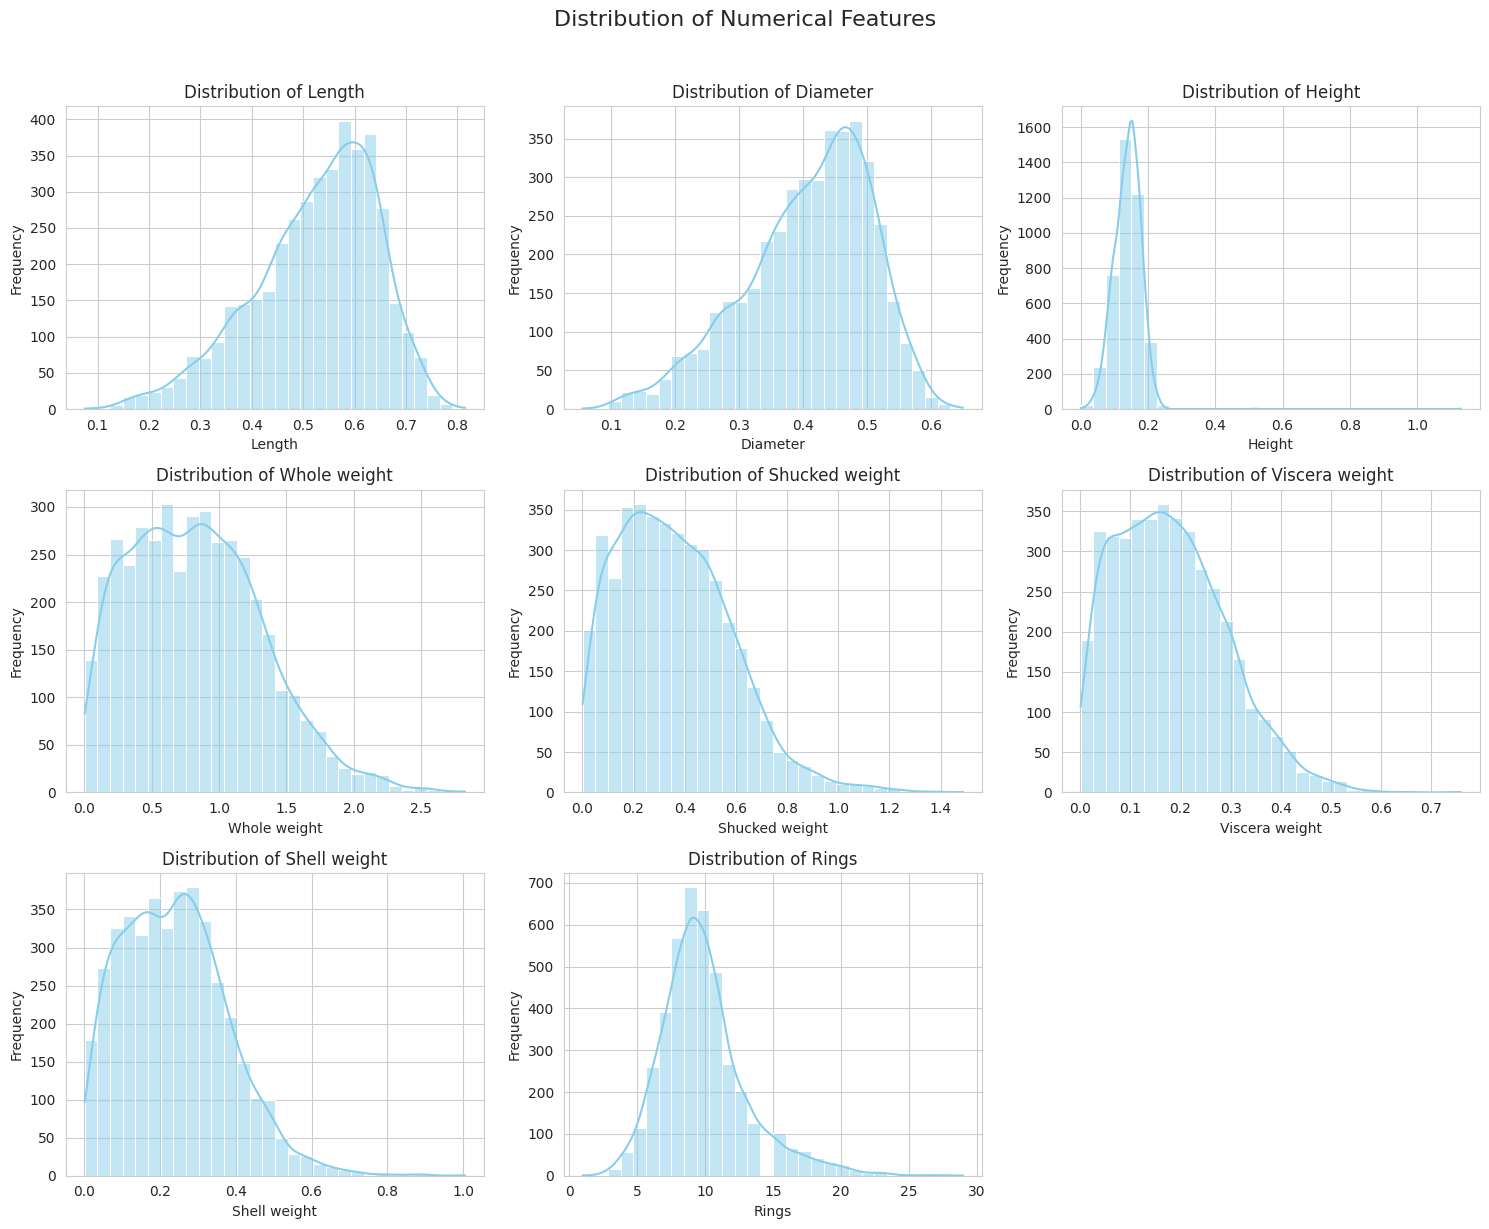

In [30]:
# Set the aesthetic style of the plots
sns.set_style('whitegrid')

# Create subplots for better organization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Visualization 1: Distribution of 'label' (binary classification target)
sns.countplot(ax=axes[0], x=df_no_duplicates['Sex'], hue=df_no_duplicates['Sex'], palette='viridis', legend=False)
axes[0].set_title('Distribution of Sex (M, F, and I (infant)) in Dataset')
axes[0].set_xlabel('Gender')
axes[0].set_ylabel('Count')

numerical_features = ['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings']

# Determine the number of rows and columns for subplots
# A 3x3 grid seems appropriate for 8 features (one will be empty)
num_features = len(numerical_features)
num_cols = 3
num_rows = (num_features + num_cols - 1) // num_cols # Calculate rows needed

plt.figure(figsize=(num_cols * 5, num_rows * 4))
plt.suptitle('Distribution of Numerical Features', y=1.02, fontsize=16)

for i, col in enumerate(numerical_features):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.histplot(df_no_duplicates[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

# plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout to prevent title overlap
# plt.show()

plt.tight_layout()
plt.show()

**Insights:**
1) Most of the abalones are Male
2) The Distribution of Rings graph is right-skewed indicating that thare are a larger number of younger abalones in the dataset.

## Feature Engineering: Creating Feature and Target Column


1.   New Feature Column:

`Volume` column is created to provide insights into how the proportion of meat changes as an abalone grows and matures.

2.   New Target Column:

To better represent the abalone's age, we will create a new `Age` column by adding 1.5 to the 'Rings' column.

In [31]:
df_no_duplicates['Volume'] = df_no_duplicates['Length'] * df_no_duplicates['Diameter'] * df_no_duplicates['Height']
df_no_duplicates['Age'] = df_no_duplicates['Rings'] + 1.5

print("First 5 records with new 'Volume' and 'Age' columns:")
display(df_no_duplicates.head())
print("\nDataFrame info after adding 'Volume' and 'Age' columns:")
display(df_no_duplicates.info())

First 5 records with new 'Volume' and 'Age' columns:


,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Volume,Age
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,0.015777,16.5
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,0.008347,8.5
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,0.030051,10.5
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,0.020075,11.5
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,0.006732,8.5



DataFrame info after adding 'Volume' and 'Age' columns:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4177 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
 9   Volume          4177 non-null   float64
 10  Age             4177 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 359.1+ KB


None

In [32]:
# Separate features (X) and target (y)
# Drop 'Rings' from features, as 'Age' (the target) is derived from it.
# 'Sex' column is kept in X for now and will be one-hot encoded after splitting.
X = df_no_duplicates.drop(['Rings', 'Age'], axis=1)
y = df_no_duplicates['Age']

# Split the data into an initial training+validation set and a test set (80/20 split)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Further split the training+validation set into training and validation sets
# This results in a 60% training, 20% validation, and 20% test split from the original dataset
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42 # 0.25 of 0.8 (80%) is 0.2 (20% validation)
)

print('X_train (new training features):')
display(X_train.info())
print('y_train (new training labels):')
display(y_train.info())
print('X_val (validation features):')
display(X_val.info())
print('y_val (validation labels):')
display(y_val.info())

print('X_test:')
display(X_test.info())
print('y_test:')
display(y_test.info())


X_train (new training features):
<class 'pandas.core.frame.DataFrame'>
Index: 2505 entries, 400 to 3419
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             2505 non-null   object 
 1   Length          2505 non-null   float64
 2   Diameter        2505 non-null   float64
 3   Height          2505 non-null   float64
 4   Whole weight    2505 non-null   float64
 5   Shucked weight  2505 non-null   float64
 6   Viscera weight  2505 non-null   float64
 7   Shell weight    2505 non-null   float64
 8   Volume          2505 non-null   float64
dtypes: float64(8), object(1)
memory usage: 195.7+ KB


None

y_train (new training labels):
<class 'pandas.core.series.Series'>
Index: 2505 entries, 400 to 3419
Series name: Age
Non-Null Count  Dtype  
--------------  -----  
2505 non-null   float64
dtypes: float64(1)
memory usage: 39.1 KB


None

X_val (validation features):
<class 'pandas.core.frame.DataFrame'>
Index: 836 entries, 1407 to 3922
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             836 non-null    object 
 1   Length          836 non-null    float64
 2   Diameter        836 non-null    float64
 3   Height          836 non-null    float64
 4   Whole weight    836 non-null    float64
 5   Shucked weight  836 non-null    float64
 6   Viscera weight  836 non-null    float64
 7   Shell weight    836 non-null    float64
 8   Volume          836 non-null    float64
dtypes: float64(8), object(1)
memory usage: 65.3+ KB


None

y_val (validation labels):
<class 'pandas.core.series.Series'>
Index: 836 entries, 1407 to 3922
Series name: Age
Non-Null Count  Dtype  
--------------  -----  
836 non-null    float64
dtypes: float64(1)
memory usage: 13.1 KB


None

X_test:
<class 'pandas.core.frame.DataFrame'>
Index: 836 entries, 866 to 1830
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             836 non-null    object 
 1   Length          836 non-null    float64
 2   Diameter        836 non-null    float64
 3   Height          836 non-null    float64
 4   Whole weight    836 non-null    float64
 5   Shucked weight  836 non-null    float64
 6   Viscera weight  836 non-null    float64
 7   Shell weight    836 non-null    float64
 8   Volume          836 non-null    float64
dtypes: float64(8), object(1)
memory usage: 65.3+ KB


None

y_test:
<class 'pandas.core.series.Series'>
Index: 836 entries, 866 to 1830
Series name: Age
Non-Null Count  Dtype  
--------------  -----  
836 non-null    float64
dtypes: float64(1)
memory usage: 13.1 KB


None

##One-Hot Encode `Sex` Column

Since `Sex` column is the only column that is not of numeric type, we will apply One Hot Encoding to convert the 'object' type values into numeric type.

In [33]:
# Define a helper function to apply one-hot encoding to the 'Sex' column in a DataFrame subset
def one_hot_encode_sex_column(df_subset):
    if 'Sex' in df_subset.columns:
        # Convert 'Sex' column to one-hot encoding
        df_encoded_sex = pd.get_dummies(df_subset['Sex'], prefix='Sex', dtype=int)
        # Concatenate the new one-hot encoded columns with the rest of the DataFrame
        # and drop the original 'Sex' column
        df_subset = pd.concat([df_subset.drop('Sex', axis=1), df_encoded_sex], axis=1)
    return df_subset

In [34]:
# Apply one-hot encoding to the 'Sex' column in X_train, X_val, X_test
X_train = one_hot_encode_sex_column(X_train)
X_val = one_hot_encode_sex_column(X_val)
X_test = one_hot_encode_sex_column(X_test)

print('First 5 records of X_train after one-hot encoding:')
display(X_train.head())
print('\nFirst 5 records of X_val after one-hot encoding:')
display(X_val.head())
print('\nFirst 5 records of X_test after one-hot encoding:')
display(X_test.head())

print('\nX_train (new training features):')
display(X_train.info())
print('y_train (new training labels):')
display(y_train.info())
print('X_val (validation features):')
display(X_val.info())
print('y_val (validation labels):')
display(y_val.info())

print('X_test:')
display(X_test.info())
print('y_test:')
display(y_test.info())

First 5 records of X_train after one-hot encoding:


,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Volume,Sex_F,Sex_I,Sex_M
400,0.485,0.365,0.120,0.5885,0.2700,0.1310,0.175,0.021243,1,0,0
1371,0.615,0.500,0.170,1.0540,0.4845,0.2280,0.295,0.052275,0,0,1
3395,0.605,0.450,0.165,1.2225,0.3570,0.2020,0.385,0.044921,1,0,0
2508,0.415,0.315,0.105,0.3300,0.1405,0.0705,0.095,0.013726,0,1,0
2704,0.700,0.525,0.175,1.7585,0.8745,0.3615,0.470,0.064312,0,0,1



First 5 records of X_val after one-hot encoding:


,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Volume,Sex_F,Sex_I,Sex_M
1407,0.655,0.490,0.175,1.3585,0.6395,0.2940,0.365,0.056166,0,0,1
1120,0.545,0.390,0.135,0.7835,0.4225,0.1815,0.156,0.028694,0,0,1
199,0.585,0.460,0.185,0.9220,0.3635,0.2130,0.285,0.049784,0,0,1
503,0.600,0.505,0.190,1.1290,0.4385,0.2560,0.360,0.057570,1,0,0
2087,0.720,0.585,0.220,1.9140,0.9155,0.4480,0.479,0.092664,0,0,1



First 5 records of X_test after one-hot encoding:


,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Volume,Sex_F,Sex_I,Sex_M
866,0.605,0.455,0.160,1.1035,0.4210,0.3015,0.325,0.044044,0,0,1
1483,0.590,0.440,0.150,0.8725,0.3870,0.2150,0.245,0.038940,0,0,1
599,0.560,0.445,0.195,0.9810,0.3050,0.2245,0.335,0.048594,1,0,0
1702,0.635,0.490,0.170,1.2615,0.5385,0.2665,0.380,0.052895,1,0,0
670,0.475,0.385,0.145,0.6175,0.2350,0.1080,0.215,0.026517,0,0,1



X_train (new training features):
<class 'pandas.core.frame.DataFrame'>
Index: 2505 entries, 400 to 3419
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Length          2505 non-null   float64
 1   Diameter        2505 non-null   float64
 2   Height          2505 non-null   float64
 3   Whole weight    2505 non-null   float64
 4   Shucked weight  2505 non-null   float64
 5   Viscera weight  2505 non-null   float64
 6   Shell weight    2505 non-null   float64
 7   Volume          2505 non-null   float64
 8   Sex_F           2505 non-null   int64  
 9   Sex_I           2505 non-null   int64  
 10  Sex_M           2505 non-null   int64  
dtypes: float64(8), int64(3)
memory usage: 234.8 KB


None

y_train (new training labels):
<class 'pandas.core.series.Series'>
Index: 2505 entries, 400 to 3419
Series name: Age
Non-Null Count  Dtype  
--------------  -----  
2505 non-null   float64
dtypes: float64(1)
memory usage: 39.1 KB


None

X_val (validation features):
<class 'pandas.core.frame.DataFrame'>
Index: 836 entries, 1407 to 3922
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Length          836 non-null    float64
 1   Diameter        836 non-null    float64
 2   Height          836 non-null    float64
 3   Whole weight    836 non-null    float64
 4   Shucked weight  836 non-null    float64
 5   Viscera weight  836 non-null    float64
 6   Shell weight    836 non-null    float64
 7   Volume          836 non-null    float64
 8   Sex_F           836 non-null    int64  
 9   Sex_I           836 non-null    int64  
 10  Sex_M           836 non-null    int64  
dtypes: float64(8), int64(3)
memory usage: 78.4 KB


None

y_val (validation labels):
<class 'pandas.core.series.Series'>
Index: 836 entries, 1407 to 3922
Series name: Age
Non-Null Count  Dtype  
--------------  -----  
836 non-null    float64
dtypes: float64(1)
memory usage: 13.1 KB


None

X_test:
<class 'pandas.core.frame.DataFrame'>
Index: 836 entries, 866 to 1830
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Length          836 non-null    float64
 1   Diameter        836 non-null    float64
 2   Height          836 non-null    float64
 3   Whole weight    836 non-null    float64
 4   Shucked weight  836 non-null    float64
 5   Viscera weight  836 non-null    float64
 6   Shell weight    836 non-null    float64
 7   Volume          836 non-null    float64
 8   Sex_F           836 non-null    int64  
 9   Sex_I           836 non-null    int64  
 10  Sex_M           836 non-null    int64  
dtypes: float64(8), int64(3)
memory usage: 78.4 KB


None

y_test:
<class 'pandas.core.series.Series'>
Index: 836 entries, 866 to 1830
Series name: Age
Non-Null Count  Dtype  
--------------  -----  
836 non-null    float64
dtypes: float64(1)
memory usage: 13.1 KB


None

All columns in the dataset have been converted to numeric data type.

## Correlation Analysis between Features and Target column `Age`


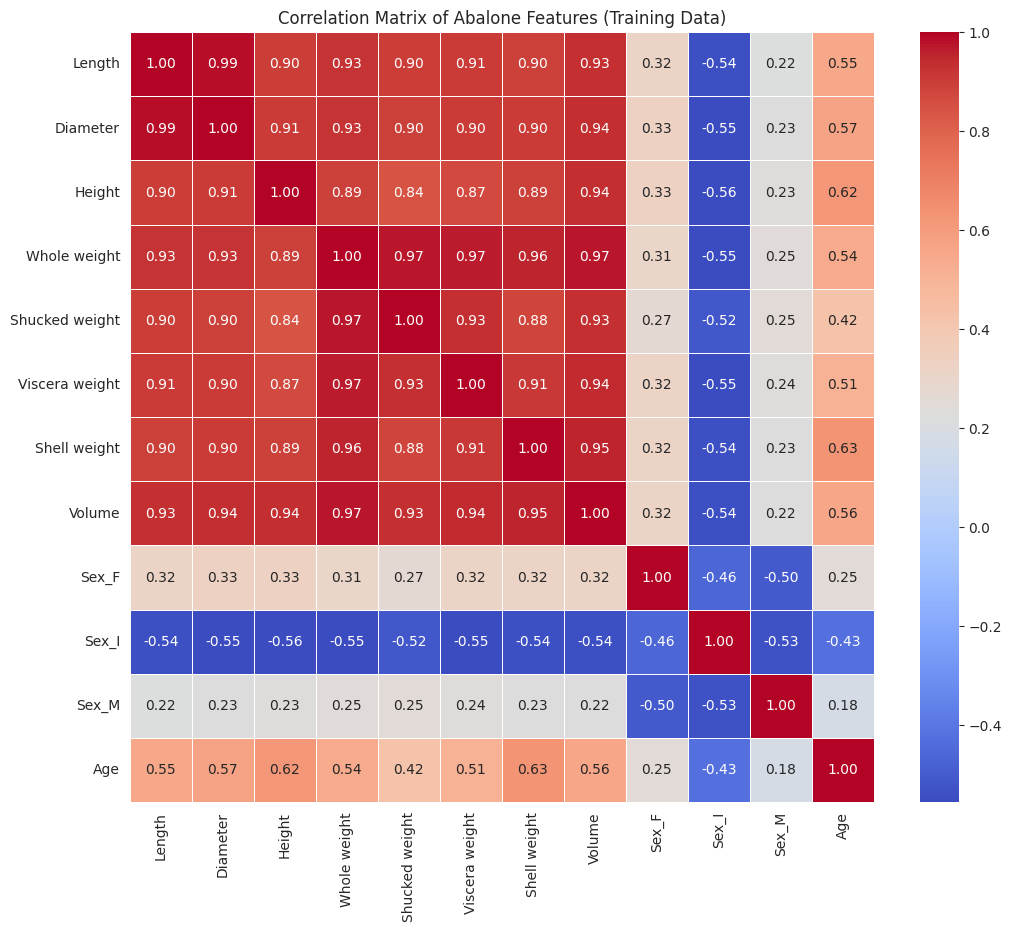

In [35]:
# Combine X_train and y_train to calculate the correlation matrix
# This ensures the correlation is based on the preprocessed features and the target variable
train_data_for_corr = pd.concat([X_train, y_train], axis=1)

correlation_matrix = train_data_for_corr.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Abalone Features (Training Data)')
plt.show()

**Insight:**
All physical measurement features (except Sex) are positively and highly correlated with `Age` (and one another) indicating that larger and heavier abalones in the dataset tend to be older.

**Intercorrelated Features:**
1) Length and Diameter
2) Whole weight and Shucked weight

## Feature Scaling: Standardizing Numerical Features

To ensure that all numerical features contribute equally to the model training and to prevent features with larger values from dominating, we will apply `StandardScaler`. This technique transforms the data such that it has a mean of 0 and a standard deviation of 1. It is crucial to fit the scaler only on the training data (`X_train`) and then use this fitted scaler to transform the validation (`X_val`) and test (`X_test`) sets to prevent data leakage.

In [36]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler ONLY on the training data (X_train)
scaler.fit(X_train)

# Transform X_train, X_val, and X_test using the fitted scaler
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled arrays back to DataFrames, preserving column names and index
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print('First 5 records of X_train_scaled:')
display(X_train_scaled.head())
print('\nX_train_scaled info:')
display(X_train_scaled.info())

print('\nFirst 5 records of X_val_scaled:')
display(X_val_scaled.head())
print('\nX_val_scaled info:')
display(X_val_scaled.info())

print('\nFirst 5 records of X_test_scaled:')
display(X_test_scaled.head())
print('\nX_test_scaled info:')
display(X_test_scaled.info())

First 5 records of X_train_scaled:


,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Volume,Sex_F,Sex_I,Sex_M
400,-0.342708,-0.450035,-0.507659,-0.497209,-0.410742,-0.459207,-0.467573,-0.651269,1.510991,-0.700132,-0.760559
1371,0.755963,0.927380,0.801873,0.456108,0.564253,0.436284,0.394178,0.842672,-0.661817,-0.700132,1.314822
3395,0.671449,0.417226,0.670919,0.801186,-0.015289,0.196255,1.040491,0.488648,1.510991,-0.700132,-0.760559
2508,-0.934300,-0.960189,-0.900519,-1.026602,-0.999375,-1.017734,-1.042074,-1.013146,-0.661817,1.428303,-0.760559
2704,1.474324,1.182457,0.932826,1.898883,2.336971,1.668737,1.650898,1.422180,-0.661817,-0.700132,1.314822



X_train_scaled info:
<class 'pandas.core.frame.DataFrame'>
Index: 2505 entries, 400 to 3419
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Length          2505 non-null   float64
 1   Diameter        2505 non-null   float64
 2   Height          2505 non-null   float64
 3   Whole weight    2505 non-null   float64
 4   Shucked weight  2505 non-null   float64
 5   Viscera weight  2505 non-null   float64
 6   Shell weight    2505 non-null   float64
 7   Volume          2505 non-null   float64
 8   Sex_F           2505 non-null   float64
 9   Sex_I           2505 non-null   float64
 10  Sex_M           2505 non-null   float64
dtypes: float64(11)
memory usage: 234.8 KB


None


First 5 records of X_val_scaled:


,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Volume,Sex_F,Sex_I,Sex_M
1407,1.094015,0.825349,0.932826,1.079706,1.268795,1.045587,0.896866,1.030004,-0.661817,-0.700132,1.314822
1120,0.164370,-0.194958,-0.114800,-0.097861,0.282436,0.007002,-0.604017,-0.292552,-0.661817,-0.700132,1.314822
199,0.502423,0.519257,1.194732,0.185779,0.014256,0.297806,0.322365,0.722726,-0.661817,-0.700132,1.314822
503,0.629193,0.978395,1.325685,0.609703,0.355163,0.694776,0.860960,1.097583,1.510991,-0.700132,-0.760559
2087,1.643351,1.794641,2.111405,2.217338,2.523333,2.467293,1.715529,2.787077,-0.661817,-0.700132,1.314822



X_val_scaled info:
<class 'pandas.core.frame.DataFrame'>
Index: 836 entries, 1407 to 3922
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Length          836 non-null    float64
 1   Diameter        836 non-null    float64
 2   Height          836 non-null    float64
 3   Whole weight    836 non-null    float64
 4   Shucked weight  836 non-null    float64
 5   Viscera weight  836 non-null    float64
 6   Shell weight    836 non-null    float64
 7   Volume          836 non-null    float64
 8   Sex_F           836 non-null    float64
 9   Sex_I           836 non-null    float64
 10  Sex_M           836 non-null    float64
dtypes: float64(11)
memory usage: 78.4 KB


None


First 5 records of X_test_scaled:


,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Volume,Sex_F,Sex_I,Sex_M
866,0.671449,0.468242,0.539966,0.557481,0.275618,1.114826,0.609616,0.446415,-0.661817,-0.700132,1.314822
1483,0.544680,0.315196,0.278060,0.084406,0.121074,0.316270,0.035115,0.200699,-0.661817,-0.700132,1.314822
599,0.291140,0.366211,1.456639,0.306608,-0.251652,0.403972,0.681428,0.665461,1.510991,-0.700132,-0.760559
1702,0.924989,0.825349,0.801873,0.881056,0.809706,0.791710,1.004585,0.872544,1.510991,-0.700132,-0.760559
670,-0.427222,-0.245973,0.147107,-0.437819,-0.569832,-0.671540,-0.180323,-0.397375,-0.661817,-0.700132,1.314822



X_test_scaled info:
<class 'pandas.core.frame.DataFrame'>
Index: 836 entries, 866 to 1830
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Length          836 non-null    float64
 1   Diameter        836 non-null    float64
 2   Height          836 non-null    float64
 3   Whole weight    836 non-null    float64
 4   Shucked weight  836 non-null    float64
 5   Viscera weight  836 non-null    float64
 6   Shell weight    836 non-null    float64
 7   Volume          836 non-null    float64
 8   Sex_F           836 non-null    float64
 9   Sex_I           836 non-null    float64
 10  Sex_M           836 non-null    float64
dtypes: float64(11)
memory usage: 78.4 KB


None

In [37]:
model_params = {
    'Linear_Regression': {
        'model': LinearRegression(),
        'params': {}, #no hyperparameters to tune for basic Linear Regression model
        'tuner': None # Explicitly set to None for direct fitting
    },
    'Random_Forest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 150],  # Number of trees
            'max_features': ['sqrt', None], # Number of features to consider at each split
            'max_depth': [10, 30],     # Maximum number of levels in tree
            'min_samples_split': [2, 5], # Minimum number of samples required to split a node
            'min_samples_leaf': [1, 5]   # Minimum number of samples required at each leaf node
        },
        'tuner': 'GridSearchCV'
    }
}

scores = []

for model_name, mp in model_params.items():
    print(f"Tuning {model_name}...")
    best_estimator = None # Initialize best_estimator
    if mp['tuner'] == 'GridSearchCV':
        # GridSearchCV requires a dict of lists for parameters
        tuner = GridSearchCV(mp['model'], mp['params'], cv=5, scoring='r2', n_jobs=-1)
        tuner.fit(X_train_scaled, y_train)
        best_score = tuner.best_score_
        best_params = tuner.best_params_
        best_estimator = tuner.best_estimator_
    elif mp['tuner'] == 'RandomizedSearchCV':
        # This block will no longer be used for RandomForest but kept for other potential models
        tuner = RandomizedSearchCV(
            mp['model'], mp['params'], n_iter=50, cv=5, scoring='r2', random_state=42, n_jobs=-1
        )
        tuner.fit(X_train_scaled, y_train)
        best_score = tuner.best_score_
        best_params = tuner.best_params_
        best_estimator = tuner.best_estimator_
    elif mp['tuner'] == None: # Handle direct fitting for models with no tuning
        mp['model'].fit(X_train_scaled, y_train)
        best_score = mp['model'].score(X_train_scaled, y_train) # Use R2 score on train data
        best_params = {} # No params tuned
        best_estimator = mp['model'] # The model itself is the best estimator
    else:
        raise ValueError(f"Unknown tuner type: {mp['tuner']}")

    scores.append({
        'model': model_name,
        'best_score': best_score,
        'best_params': best_params,
        'best_estimator': best_estimator # Add the best_estimator here
    })

results_df = pd.DataFrame(scores)
print(results_df.sort_values(by='best_score', ascending=False))

Tuning Linear_Regression...
Tuning Random_Forest...
               model  best_score  \
0  Linear_Regression    0.565156   
1      Random_Forest    0.551943   

                                         best_params  \
0                                                 {}   
1  {'max_depth': 10, 'max_features': None, 'min_s...   

                                      best_estimator  
0                                 LinearRegression()  
1  (DecisionTreeRegressor(max_depth=10, min_sampl...  


In [38]:
# Assuming 'scores' list contains dictionaries with 'model' and 'best_estimator' keys
for model_result in scores:
    best_model = model_result['best_estimator']
    model_name = model_result['model']

    y_pred = best_model.predict(X_test_scaled)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"Final Test Results for {model_name} ({type(best_model).__name__}):")
    print(f"{'-'*40}")
    print(f"R2 Score: {r2:.4f}  (Closer to 1.0 is better)")
    print(f"MAE:      {mae:.4f}  (Average error in Age/Years)")
    print(f"RMSE:     {rmse:.4f}  (Penalizes larger errors)")
    print("\n")

Final Test Results for Linear_Regression (LinearRegression):
----------------------------------------
R2 Score: 0.5426  (Closer to 1.0 is better)
MAE:      1.6004  (Average error in Age/Years)
RMSE:     2.2251  (Penalizes larger errors)


Final Test Results for Random_Forest (RandomForestRegressor):
----------------------------------------
R2 Score: 0.5441  (Closer to 1.0 is better)
MAE:      1.5688  (Average error in Age/Years)
RMSE:     2.2216  (Penalizes larger errors)




####Calculating Adjusted R2 score for Models

Adjusted R2 score is a better evaluation metric then R2 as it prioritises the input features that have a higher correlation with the target variable. This means that **new redundant** input features will cause the adjusted R2 score to decrease, as compared to R2 score which increases as long as the number of input features increases.

In [39]:
n = X_test_scaled.shape[0] # Number of observations (using test set for evaluation)
p = X_test_scaled.shape[1] # Number of features

print(f"Number of observations (n): {n}")
print(f"Number of features (p): {p}")

adjusted_r2_scores = []

for model_result in scores:
    best_model = model_result['best_estimator']
    model_name = model_result['model']

    y_pred = best_model.predict(X_test_scaled)
    r2 = r2_score(y_test, y_pred)

    # Calculate Adjusted R2
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    adjusted_r2_scores.append({'model': model_name, 'Adjusted R2': adjusted_r2})

adjusted_r2_df = pd.DataFrame(adjusted_r2_scores)
print('\nAdjusted R2 Scores:')
display(adjusted_r2_df.sort_values(by='Adjusted R2', ascending=False))

Number of observations (n): 836
Number of features (p): 11

Adjusted R2 Scores:


,model,Adjusted R2
1,Random_Forest,0.537974
0,Linear_Regression,0.536513


**Better performing model: `Random Forest Regressor`**


1.   Lower Adjusted R2 (R-squared) score: Random Forest Regressor explains a bit more about variance in 'Age' of abalone considering **more useful** features
2.   Lower MAE (Mean Absolute Error): Random Forest Regressor's age predictions are closer to the actual values.
3.   Lower RMSE (Root Mean Square Error): Random Forest Regressor makes fewer large prediction errors.



## Visualize Feature Importances and Predicted vs. Actual Values


**Reasoning**:
The previous code generated a `FutureWarning` due to `palette` being passed without `hue` in `sns.barplot`. I will modify the `sns.barplot` call to explicitly set `hue` to the `x` variable and `legend` to `False` to address this warning.



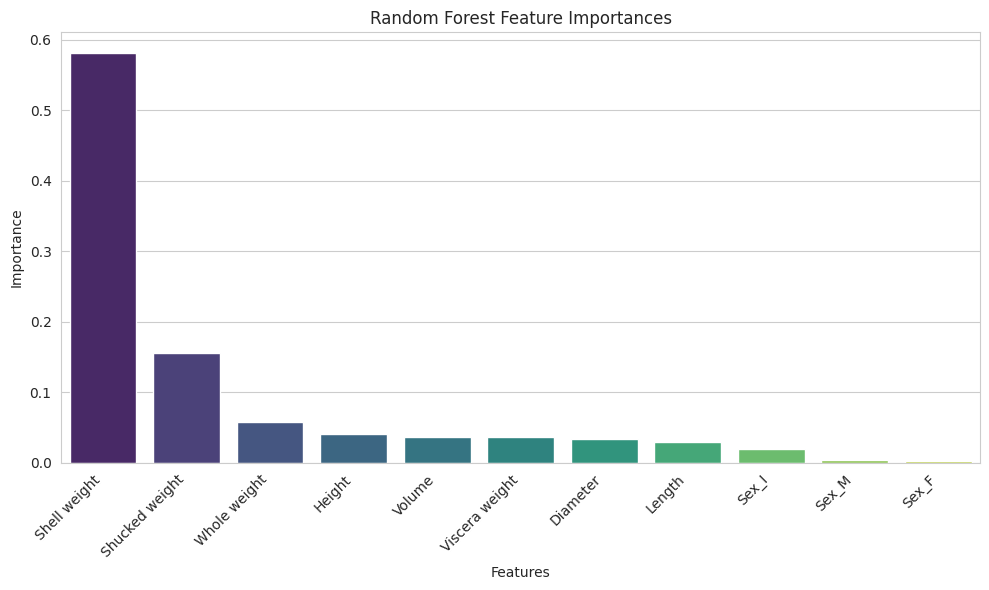

In [40]:
# 1. Extract the RandomForestRegressor model's best_estimator
best_rf_estimator = results_df[results_df['model'] == 'Random_Forest']['best_estimator'].iloc[0]

# 2. Get the feature importances
feature_importances = best_rf_estimator.feature_importances_

# 3. Create a Pandas Series of feature importances
# Ensure X_train_scaled.columns is used as X_train.columns might contain 'Sex' instead of one-hot encoded columns
feature_importances_series = pd.Series(feature_importances, index=X_train_scaled.columns)

# 4. Sort the feature importances in descending order
sorted_feature_importances = feature_importances_series.sort_values(ascending=False)

# Create a bar plot of these sorted feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_feature_importances.index, y=sorted_feature_importances.values, palette='viridis', hue=sorted_feature_importances.index, legend=False)
plt.title('Random Forest Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

This graph demonstrates that `Shell weight` is the most influential feature in predicting `Age`.

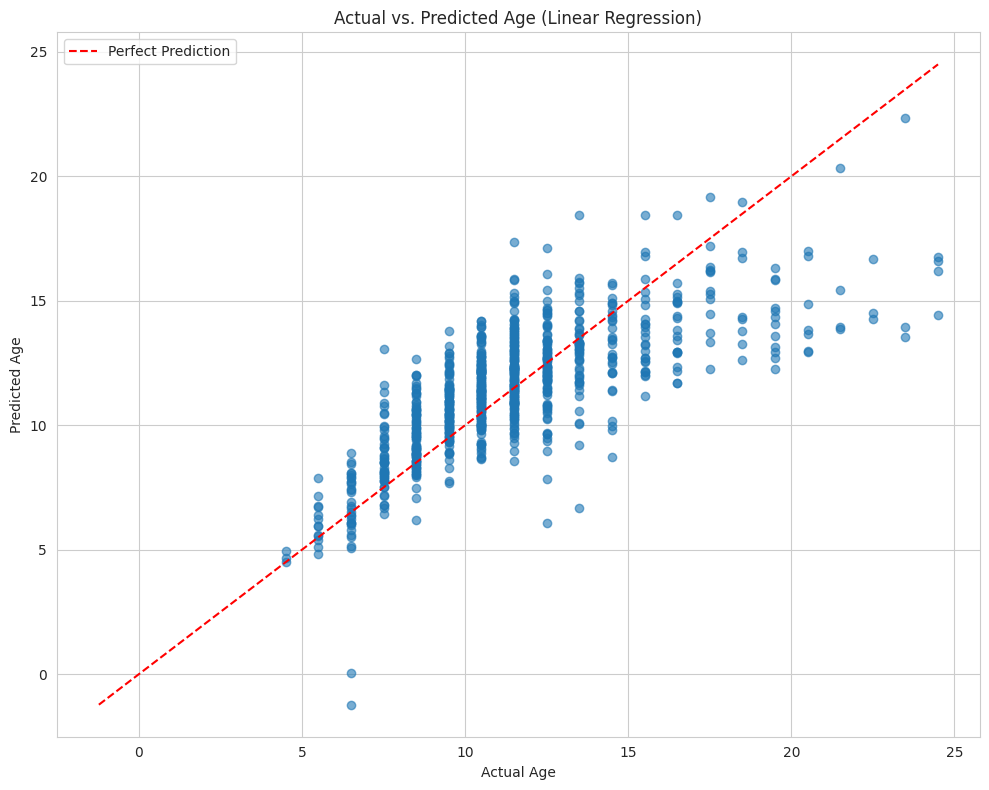

In [41]:
# Extract the Linear Regression model's best_estimator
best_lr_estimator = results_df[results_df['model'] == 'Linear_Regression']['best_estimator'].iloc[0]

# Make predictions using the Linear Regression model on the scaled test set
y_pred_lr = best_lr_estimator.predict(X_test_scaled)

# Create a scatter plot with y_test on the x-axis and y_pred_lr on the y-axis
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred_lr, alpha=0.6)
plt.title('Actual vs. Predicted Age (Linear Regression)')
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')

# On the scatter plot, add a diagonal line representing perfect predictions
min_val_lr = min(y_test.min(), y_pred_lr.min())
max_val_lr = max(y_test.max(), y_pred_lr.max())
plt.plot([min_val_lr, max_val_lr], [min_val_lr, max_val_lr], 'r--', label='Perfect Prediction')

# Add a legend to the scatter plot
plt.legend()

# Adjust layout and display plots
plt.tight_layout()
plt.show()

The above graph shows that the predicted data points are concentrated at abalones with actual age values between ~5 and ~19 while the data points for older abalones deviate more from the best fit line (perfect prediction). This implies that the Linear Regression model is more confident in predicting younger abalones.

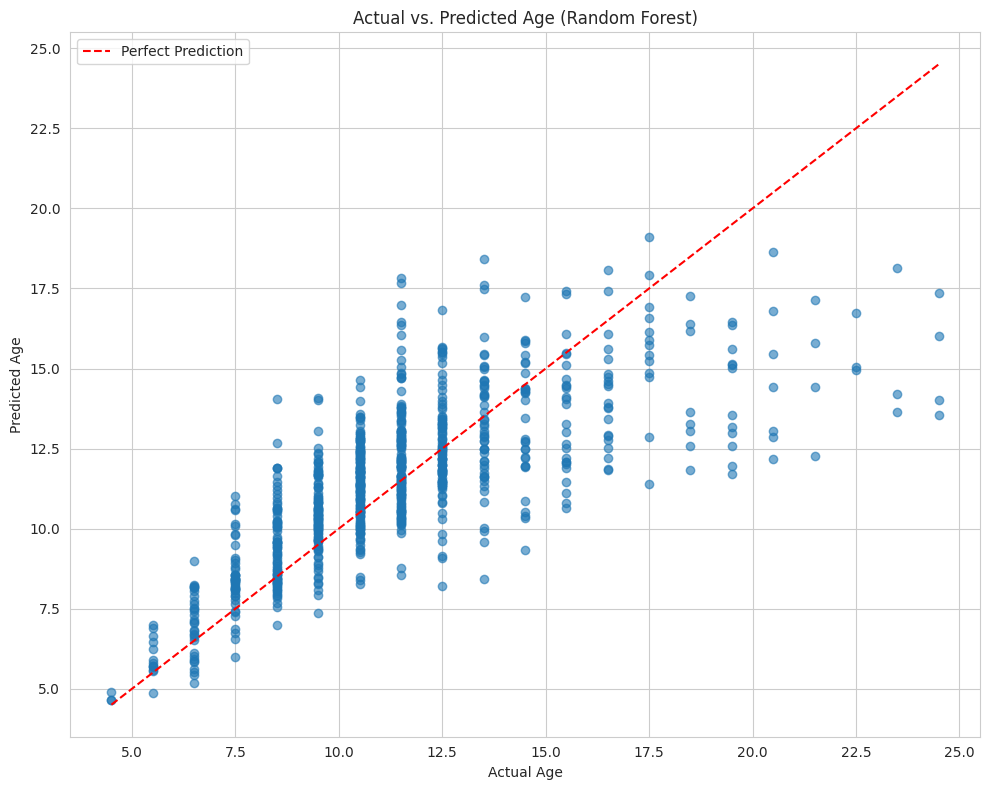

In [42]:
# Using the y_pred from the last model evaluated (RandomForest) which is stored in the variable `y_pred`

# Create a scatter plot with y_test on the x-axis and y_pred on the y-axis
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.title('Actual vs. Predicted Age (Random Forest)')
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')

# On the scatter plot, add a diagonal line representing perfect predictions
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')

# Add a legend to the scatter plot
plt.legend()

# Adjust layout and display plots
plt.tight_layout()
plt.show()

The above graph shows that the Random forest model is also more confident in predicting younger abalones as variance increases with higher actual age values. However, the data points are clustered closer to the best fit line (perfect prediction), meaning the Random Forest Regressor abalone age predictions are more precise than that of Linear Regression model.